In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# --- IMPORTS FROM YOUR HELPERS ---
from helpers.benchmark import load_records_from_directory, metric_for_benchmark
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba
from helpers.cpus import clean_cpu_string, shorten_cpu_name, get_cpu_palette


import pandas as pd

WEEK_EXPERIMENT_ROOT = "data/stage_c" 
PARQUET_CACHE = "cache/stage_c.parquet"

cache_path = Path(PARQUET_CACHE)

if cache_path.exists():
    print(f"Loading cached dataframe from {cache_path} ...")
    df = pd.read_parquet(cache_path)
else:
    print("Cache not found – loading from raw directory ...")
    df = load_records_from_directory(WEEK_EXPERIMENT_ROOT)
    print(f"Loaded {len(df)} total records from Stage C experiments.")
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(cache_path, index=False)
    print(f"Wrote cache to {cache_path}")


# print example how time is converted 
example_utc = df["timestamp"].iloc[0]
# print timezone of that first example
print(f"Example UTC time: {example_utc} (timezone: {example_utc.tzinfo})")
example_azure = example_utc.tz_convert("Europe/Berlin")
example_aws = example_utc.tz_convert("America/New_York")
print(f"Example UTC time: {example_utc}")
print(f"Example Azure local time: {example_azure}")
print(f"Example AWS/GCP/Alibaba local time: {example_aws}")




# Correct timestamps from utc to local timezone
# timestamps are utc: azure is germany (utc+1), aws, gcp, alibaba are us-east (utc-5)
def correct_timestamp(row):
    if row["cloud_provider"] == "azure":
        return row["timestamp"].tz_convert("Europe/Berlin")
    else:
        return row["timestamp"].tz_convert("America/New_York")


week_start = pd.Timestamp("2025-12-01", tz="UTC")
week_end = pd.Timestamp("2025-12-08", tz="UTC")  # exclusive
df = df[(df["timestamp"] >= week_start) & (df["timestamp"] < week_end)].copy()


Loading cached dataframe from cache/stage_c.parquet ...
Example UTC time: 2025-12-01 00:01:38+00:00 (timezone: UTC)
Example UTC time: 2025-12-01 00:01:38+00:00
Example Azure local time: 2025-12-01 01:01:38+01:00
Example AWS/GCP/Alibaba local time: 2025-11-30 19:01:38-05:00


In [2]:
# ----- add billed duration from cloud providers -----
billed_alibaba_df = load_all_billed_alibaba(f"data/stage_c/billed/alibaba")
df = inject_billed_alibaba(df, billed_alibaba_df)

billed_azure_df = load_all_billed_azure(f"data/stage_c/billed/azure")
df = inject_billed_azure(df, billed_azure_df)

billed_aws_df = load_all_billed_aws(f"data/stage_c/billed/aws")
df = inject_billed_aws(df, billed_aws_df)

billed_gcp_df = load_all_billed_gcp(f"data/stage_c/billed/gcp")
df = inject_billed_gcp(df, billed_gcp_df)


📥 Loaded 514007 billed Alibaba records from 5 files.
✅ All Alibaba entries matched billed durations.
📥 Loaded 485673 billed Azure records from 5 files.
⚠️ 10 Azure entries have no billed duration match.
📥 Loaded 449996 billed AWS records from 45 files.
⚠️ 4 AWS entries have no billed duration match.
📥 Loaded 450000 billed GCP records from 45 files.
✅ All GCP entries matched billed durations.


Running Decomposition...
  Processing gemm...
  Processing sha256...
  Processing gzip...
  Processing aesCtr...
  Processing json...


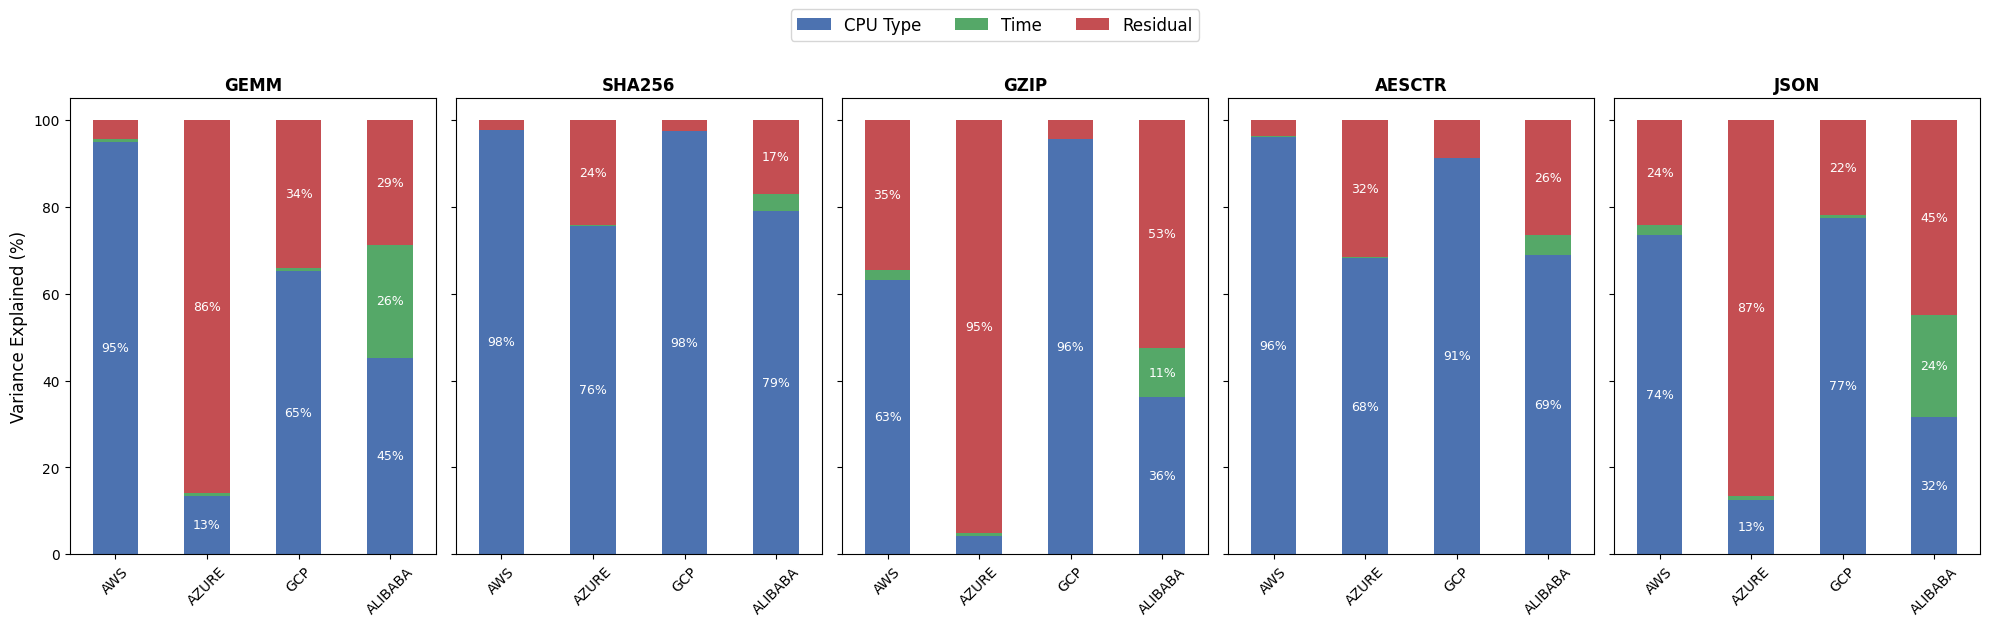

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from helpers.benchmark import filter_cpu_data, metric_for_benchmark

# --- 1. Data Preparation ---
def analyze_provider(provider, df, benchmark_type):
    memory_size = 512
    
    # Ensure timestamp is datetime
    if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Use the centralized filtering function
    df_filtered = filter_cpu_data(
        df=df,
        provider=provider,
        memory_size=memory_size,
        benchmark=benchmark_type,
        group_on_timestamp=False,
        region=None,
        remove_cold=True
    )
    
    if df_filtered.empty:
        return pd.DataFrame()
    
    metric = metric_for_benchmark(benchmark_type)
    
    # Aggregate to per-instance means
    per_instance = (
        df_filtered
        .groupby(["instance_id", "cpu_type"], as_index=False)
        .agg({metric: "mean", "timestamp": "min"})
        .rename(columns={metric: "mean_benchmark_time_ms"})
    )
    
    # Binning: floor('h') groups into hourly buckets
    per_instance["time_bin"] = per_instance["timestamp"].astype(str)
    
    return per_instance

# --- 2. Variance Decomposition ---
def get_variance_decomposition(df):
    if df.empty or df["cpu_type"].nunique() < 2:
        return None

    try:
        model = ols('mean_benchmark_time_ms ~ C(cpu_type) + C(time_bin)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        ss_total = anova_table['sum_sq'].sum()
        
        if ss_total == 0:
            return None

        results = {}
        results['CPU Type'] = (anova_table.loc['C(cpu_type)', 'sum_sq'] / ss_total) * 100
        
        if 'C(time_bin)' in anova_table.index:
            results['Time'] = (anova_table.loc['C(time_bin)', 'sum_sq'] / ss_total) * 100
        else:
            results['Time'] = 0.0
            
        results['Residual'] = (anova_table.loc['Residual', 'sum_sq'] / ss_total) * 100
        return results
        
    except Exception as e:
        return None

# --- 3. Execution Loop ---
benchmarks = ["gemm", "sha256", "gzip", "aesCtr", "json"]
providers = ["aws", "azure", "gcp", "alibaba"]

all_results = []

print("Running Decomposition...")
for bench in benchmarks:
    print(f"  Processing {bench}...")
    for provider in providers:
        df_prov = analyze_provider(provider, df, benchmark_type=bench)
        
        if not df_prov.empty:
            decomp = get_variance_decomposition(df_prov)
            if decomp:
                decomp["Provider"] = provider.upper()
                decomp["Benchmark"] = bench
                all_results.append(decomp)

# --- 4. Plotting ---
if all_results:
    full_df = pd.DataFrame(all_results)
    
    fig, axes = plt.subplots(nrows=1, ncols=len(benchmarks), figsize=(20, 6), sharey=True)
    
    colors = {"CPU Type": "#4c72b0", "Time": "#55a868", "Residual": "#c44e52"}

    for i, bench in enumerate(benchmarks):
        ax = axes[i]
        
        data = full_df[full_df["Benchmark"] == bench].set_index("Provider")
        plot_data = data[["CPU Type", "Time", "Residual"]]
        
        plot_data.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in plot_data.columns], legend=False)
        
        ax.set_title(bench.upper(), fontsize=12, fontweight='bold')
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)
        
        for c in ax.containers:
            labels = [f'{v.get_height():.0f}%' if v.get_height() > 10 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=9)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=12)
    
    axes[0].set_ylabel("Variance Explained (%)", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No sufficient data found for decomposition.")


💾 Saved to: ../holy/graphs/StageC/aws/cpu_share/stage_c_cpu_share_aws_512mb.pdf


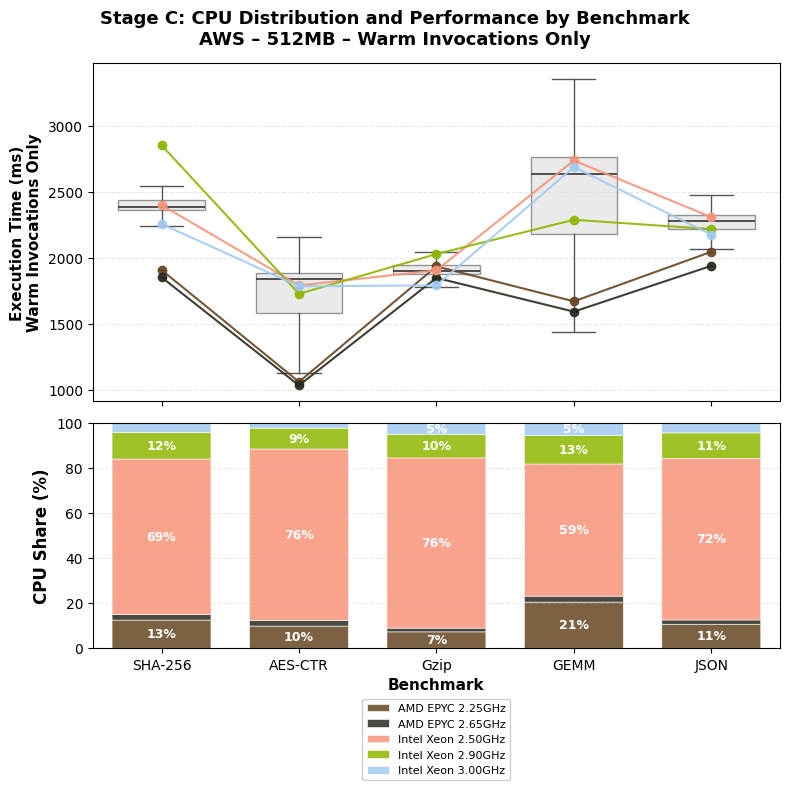


💾 Saved to: ../holy/graphs/StageC/azure/cpu_share/stage_c_cpu_share_azure_512mb.pdf


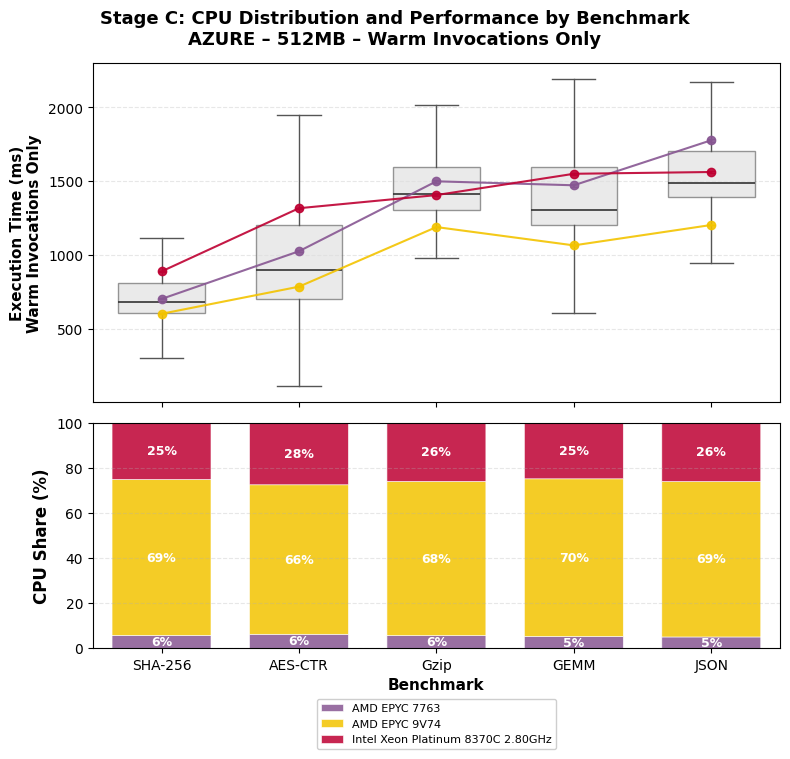


💾 Saved to: ../holy/graphs/StageC/gcp/cpu_share/stage_c_cpu_share_gcp_512mb.pdf


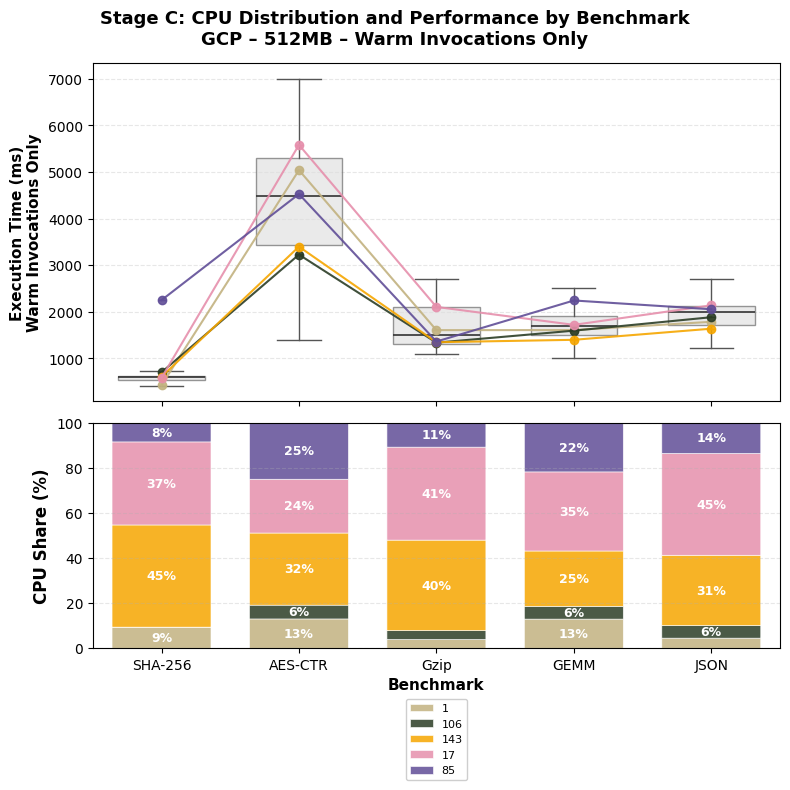


💾 Saved to: ../holy/graphs/StageC/alibaba/cpu_share/stage_c_cpu_share_alibaba_512mb.pdf


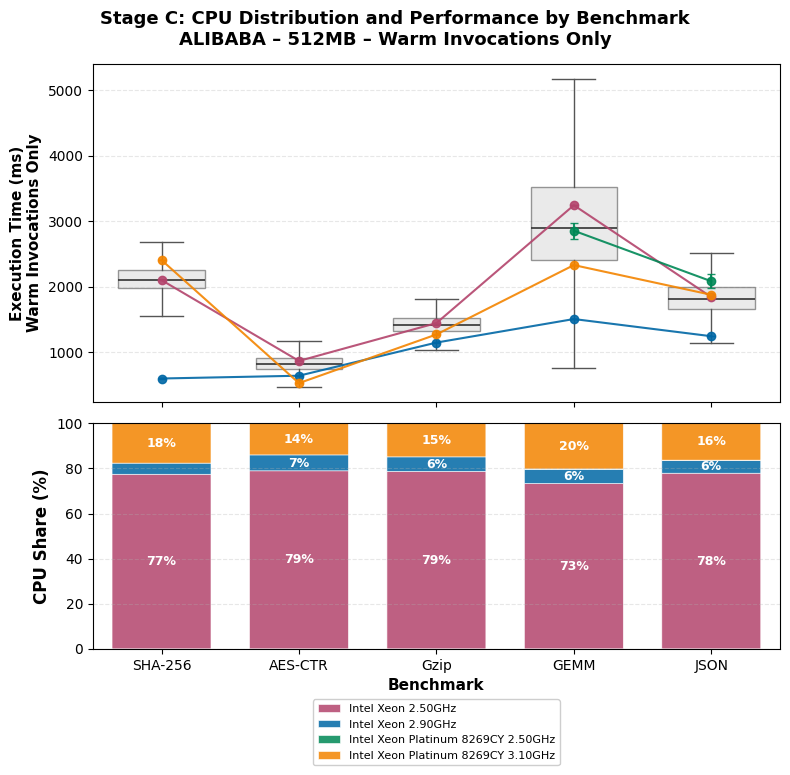

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import FancyBboxPatch
from helpers.cpus import shorten_cpu_name, get_cpu_palette
from helpers.benchmark import metric_for_benchmark
from helpers.benchmark import filter_cpu_data


def plot_stage_c_cpu_share(
    df,
    provider,
    memory_size=512,
    benchmarks=None,
    save_dir="../holy/graphs/StageC",
):
    """
    Stage C stacked bar + performance plot:
    - One provider
    - 512MB (by default)
    - X-axis: benchmark types (sha256, aesCtr, gzip, gemm, json)
    - Bottom subplot: CPU share (%) per benchmark (stacked bars)
    - Top subplot: per-CPU mean performance (points + error bars)
      + platform-wide distribution as a boxplot per benchmark
    """

    if benchmarks is None:
        benchmarks = ["sha256", "aesCtr", "gzip", "gemm", "json"]

    results = []
    used_benchmarks = []
    box_data = {}  # NEW: raw metric values per benchmark (for boxplots)

    # --- Collect data for CPU share + performance + boxplots ---
    for benchmark in benchmarks:
        df_filtered = filter_cpu_data(
            df, provider=provider, memory_size=memory_size, benchmark=benchmark, group_on_timestamp=True
        )

        if df_filtered.empty:
            print(f"⚠️  No data for {provider} {memory_size}MB – {benchmark}")
            continue

        used_benchmarks.append(benchmark)

        metric = metric_for_benchmark(benchmark)
        cpu_group = df_filtered.groupby("cpu_type")

        cpu_counts = cpu_group.size()
        total = cpu_counts.sum()

        stats = cpu_group[metric].agg(["mean", "sem", "count"])

        # Store all metric values for the platform-wide distribution
        box_data[benchmark] = df_filtered[metric].to_numpy()

        for cpu in stats.index:
            count = int(cpu_counts.loc[cpu])
            percentage = count / total * 100.0
            mean_ms = float(stats.loc[cpu, "mean"])
            sem_val = stats.loc[cpu, "sem"]
            sem_ms = float(sem_val) if not np.isnan(sem_val) else 0.0

            results.append(
                {
                    "provider": provider,
                    "benchmark": benchmark,
                    "cpu_type": cpu,
                    "memory_size": memory_size,
                    "count": count,
                    "percentage": percentage,
                    "mean_ms": mean_ms,
                    "sem_ms": sem_ms,
                }
            )

    if not results:
        print("❌ No data to plot for any benchmark")
        return

    results_df = pd.DataFrame(results)

    # Keep benchmark order in which we actually have data
    used_benchmarks = list(dict.fromkeys(used_benchmarks))

    provider_cpus = sorted(results_df["cpu_type"].unique())

    # Nice labels for the x-axis
    pretty_bench = {
        "sha256": "SHA-256",
        "aesCtr": "AES-CTR",
        "gzip": "Gzip",
        "gemm": "GEMM",
        "json": "JSON",
    }

    n_bench = len(used_benchmarks)
    x_positions = np.arange(n_bench)
    bar_width = 0.7

    # --- Build CPU share pivot: benchmark -> {cpu_type: percentage} ---
    share_pivot = {}
    for bench in used_benchmarks:
        bench_data = results_df[results_df["benchmark"] == bench]
        share_pivot[bench] = {
            row["cpu_type"]: row["percentage"]
            for _, row in bench_data.iterrows()
        }

    # --- Build performance pivot: mean + sem in ms ---
    perf_mean = (
        results_df.pivot_table(
            index="benchmark",
            columns="cpu_type",
            values="mean_ms",
            aggfunc="mean",
        )
        .reindex(used_benchmarks)
    )

    perf_sem = (
        results_df.pivot_table(
            index="benchmark",
            columns="cpu_type",
            values="sem_ms",
            aggfunc="mean",
        )
        .reindex(used_benchmarks)
    )

    # Provider-aware colors for CPUs
    palette = get_cpu_palette(provider_cpus, provider=provider)

    # --- Figure with two subplots: performance (top) + CPU share (bottom) ---
    fig, (ax_perf, ax_share) = plt.subplots(
        2,
        1,
        figsize=(8, 9),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 2]},
    )

    # =========================
    # 1) PERFORMANCE PER CPU + BOX PLOTS
    # =========================

    # 1a) Platform-wide boxplots per benchmark
    box_values = [box_data[b] for b in used_benchmarks]
    bp = ax_perf.boxplot(
        box_values,
        positions=x_positions,
        widths=bar_width * 0.9,
        showfliers=False,
        patch_artist=True,
        manage_ticks=False,
    )

    # Style the boxplots a bit
    for box in bp["boxes"]:
        box.set_facecolor("#dddddd")
        box.set_alpha(0.6)
        box.set_edgecolor("#555555")
        box.set_linewidth(1.0)

    for median in bp["medians"]:
        median.set_color("#333333")
        median.set_linewidth(1.2)

    for whisker in bp["whiskers"]:
        whisker.set_color("#555555")
        whisker.set_linewidth(1.0)

    for cap in bp["caps"]:
        cap.set_color("#555555")
        cap.set_linewidth(1.0)

    # 1b) CPU-specific mean + SEM overlaid as points/lines
    for cpu in provider_cpus:
        if cpu not in perf_mean.columns:
            continue

        y = perf_mean[cpu].values
        yerr = perf_sem[cpu].values if cpu in perf_sem.columns else np.zeros_like(y)

        mask = ~np.isnan(y)
        if not np.any(mask):
            continue

        ax_perf.errorbar(
            x_positions[mask],
            y[mask],
            yerr=np.nan_to_num(yerr[mask]),
            marker="o",
            linestyle="-",
            linewidth=1.5,
            capsize=3,
            color=palette.get(cpu, "#333333"),
            alpha=0.9,
            zorder=3,  # on top of boxplots
        )

    ax_perf.set_ylabel(
        "Execution Time (ms)\nWarm Invocations Only",
        fontweight="bold",
        fontsize=11,
    )
    ax_perf.grid(True, axis="y", linestyle="--", alpha=0.3)

    # =========================
    # 2) CPU SHARE (STACKED)
    # =========================
    bottom_positions = np.zeros(n_bench)
    legend_entries = {}

    for cpu_name in provider_cpus:
        heights = [share_pivot[bench].get(cpu_name, 0.0) for bench in used_benchmarks]

        for i, height in enumerate(heights):
            if height <= 0:
                continue

            x_pos = x_positions[i] - bar_width / 2.0
            y_pos = bottom_positions[i]
            color = palette.get(cpu_name, "#333333")

            # Rounded stacked segment
            box = FancyBboxPatch(
                (x_pos, y_pos),
                bar_width,
                height,
                boxstyle="round,pad=0.01",
                edgecolor="white",
                facecolor=color,
                linewidth=0.5,
                alpha=0.85,
                transform=ax_share.transData,
            )
            ax_share.add_patch(box)

            # Percentage label inside segment (only if big enough)
            if height > 5:
                ax_share.text(
                    x_positions[i],
                    y_pos + height / 2.0,
                    f"{height:.0f}%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="white",
                    fontsize=9,
                )

            # One legend entry per CPU
            if cpu_name not in legend_entries:
                legend_entries[cpu_name] = (box, shorten_cpu_name(cpu_name, 35))

        bottom_positions += np.array(heights)

    ax_share.set_xticks(x_positions)
    ax_share.set_xticklabels(
        [pretty_bench.get(b, b) for b in used_benchmarks],
        fontsize=10,
    )
    ax_share.set_xlabel("Benchmark", fontweight="bold", fontsize=11)
    ax_share.set_ylabel("CPU Share (%)", fontweight="bold", fontsize=12)

    ax_share.set_ylim(0, 100)
    ax_share.set_xlim(-0.5, n_bench - 0.5)
    ax_share.grid(True, axis="y", linestyle="--", alpha=0.3)

    # --- Title ---
    fig.suptitle(
        f"Stage C: CPU Distribution and Performance by Benchmark\n"
        f"{provider.upper()} – {memory_size}MB – Warm Invocations Only",
        fontsize=13,
        fontweight="bold",
        y=0.96,
    )

    # --- Legend (CPU types) below the bottom subplot ---
    if legend_entries:
        handles = [entry[0] for entry in legend_entries.values()]
        labels = [entry[1] for entry in legend_entries.values()]
        ax_share.legend(
            handles,
            labels,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.20),
            framealpha=0.95,
            fontsize=8,
            ncol=1,
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.25)

    # --- Save next to your other Stage C graphs ---
    if save_dir:
        out_dir = os.path.join(save_dir, provider, "cpu_share")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(
            out_dir, f"stage_c_cpu_share_{provider}_{memory_size}mb.pdf"
        )
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"\n💾 Saved to: {out_path}")

    plt.show()


# Calls stay the same:
plot_stage_c_cpu_share(df, "aws", memory_size=512)
plot_stage_c_cpu_share(df, "azure", memory_size=512)
plot_stage_c_cpu_share(df, "gcp", memory_size=512)
plot_stage_c_cpu_share(df, "alibaba", memory_size=512)


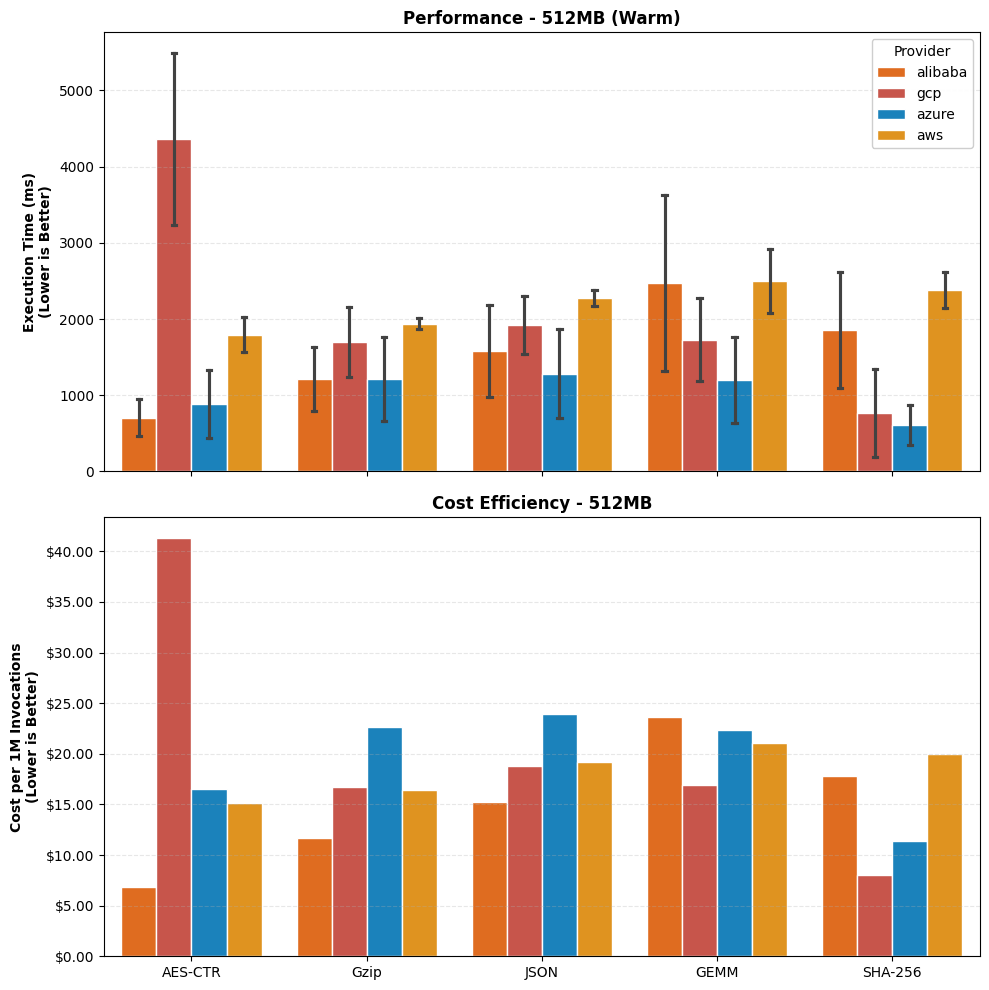

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from helpers.benchmark import metric_for_benchmark 
from helpers.cost import calculate_cost

def plot_performance_and_cost(df, benchmarks=None, memory_size=512):
    if benchmarks is None:
        benchmarks = ["sha256", "aesCtr", "gzip", "gemm", "json"]
    
    # 1. Filter Data safely
    # Check if column is 'benchmark' or 'benchmark_type'
    bench_col = "benchmark_type" if "benchmark_type" in df.columns else "benchmark"
    
    subset = df[
        (df["memory_size_mb"] == memory_size) & 
        (df[bench_col].isin(benchmarks))
    ].copy()

    if subset.empty:
        print(f"⚠️ No data found for {memory_size}MB.")
        return

    # 2. Consolidate Duration (Handle different metric names)
    subset["duration_ms"] = np.nan
    for bench in benchmarks:
        metric_col = metric_for_benchmark(bench)
        mask = subset[bench_col] == bench
        if metric_col in subset.columns:
            subset.loc[mask, "duration_ms"] = subset.loc[mask, metric_col]
    
    # Drop rows where we couldn't find a duration
    subset = subset.dropna(subset=["duration_ms"])

    # 3. APPLY COST LOGIC (The new clean way)
    # We use a lambda to map the columns to our standalone function
    subset["cost_usd"] = subset.apply(
        lambda row: calculate_cost(
            provider=row["provider"],
            memory_mb=row["memory_size_mb"],
            duration_ms=row["duration_ms"]
        ), axis=1
    )
    
    # Calculate "Cost per 1 Million" for readability
    subset["cost_per_1m"] = subset["cost_usd"] * 1_000_000

    # 4. Plotting
    pretty_names = {
        "sha256": "SHA-256", "aesCtr": "AES-CTR", 
        "gzip": "Gzip", "gemm": "GEMM", "json": "JSON"
    }
    subset["Benchmark Name"] = subset[bench_col].map(pretty_names).fillna(subset[bench_col])
    
    provider_colors = {
        "aws": "#FF9900",      # AWS Orange
        "azure": "#0089D6",    # Azure Blue
        "gcp": "#DB4437",      # Google Red
        "alibaba": "#FF6600"   # Alibaba Orange (Adjusted)
    }

    fig, (ax_time, ax_cost) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Top Plot: Execution Time
    sns.barplot(
        data=subset, x="Benchmark Name", y="duration_ms", hue="provider",
        palette=provider_colors, errorbar="sd", capsize=0.1, ax=ax_time,
        edgecolor="white", linewidth=1
    )
    ax_time.set_ylabel("Execution Time (ms)\n(Lower is Better)", fontweight='bold')
    ax_time.set_title(f"Performance - {memory_size}MB (Warm)", fontweight='bold', fontsize=12)
    ax_time.grid(axis='y', linestyle='--', alpha=0.3)
    ax_time.legend(title="Provider", loc='upper right', framealpha=0.95)

    # Bottom Plot: Cost
    sns.barplot(
        data=subset, x="Benchmark Name", y="cost_per_1m", hue="provider",
        palette=provider_colors, errorbar=None, ax=ax_cost,
        edgecolor="white", linewidth=1
    )
    
    # Currency Formatting ($5.00)
    fmt = '${x:,.2f}'
    ax_cost.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    
    ax_cost.set_ylabel("Cost per 1M Invocations\n(Lower is Better)", fontweight='bold')
    ax_cost.set_title(f"Cost Efficiency - {memory_size}MB", fontweight='bold', fontsize=12)
    ax_cost.grid(axis='y', linestyle='--', alpha=0.3)
    ax_cost.get_legend().remove() # Remove duplicate legend
    ax_cost.set_xlabel("")

    plt.tight_layout()
    plt.show()

# Example Usage:
# plot_performance_and_cost(df, memory_size=512)
# plot_performance_and_cost(df, memory_size=2048)
# Run the updated function
plot_performance_and_cost(df, memory_size=512)

<Axes: xlabel='multiplication_time_ms', ylabel='Proportion'>

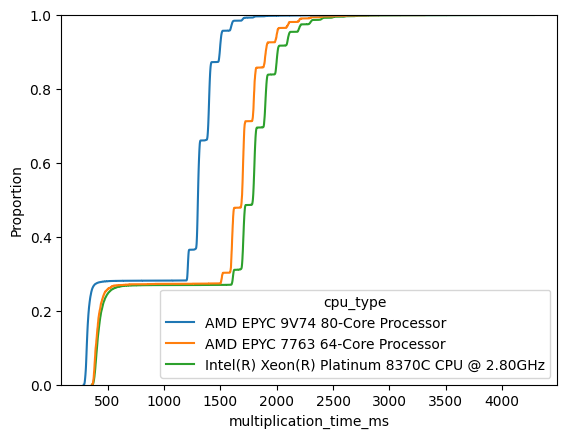

In [2]:
subset = df[(df["provider"] == "azure" ) & (df["memory_size_mb"] == 512) & (df["benchmark_type"] == "gemm")]


sns.ecdfplot(data=subset, x="multiplication_time_ms", hue="cpu_type")

In [4]:
import os
from helpers.benchmark import filter_cpu_data


def plot_experiment_trend_robust(df, provider, memory_size=512, benchmark="gemm", 
                                 save_dir="../holy/graphs/StageC",
                                 start_time=None, end_time=None):
    """
    Temporal dynamics visualization:
    - Top Panel: Performance trends per CPU type with 95% CI
    - Bottom Panel: CPU distribution over time (stacked bar)
    
    Parameters:
    -----------
    start_time : str or datetime, optional
        Start date in UTC (e.g., "2025-11-03"). Includes all experiments from start of this day.
    end_time : str or datetime, optional
        End date in UTC (e.g., "2025-11-10"). Includes all experiments up to end of this day.
    
    Note: Experiments run every 6 hours at 23:00, 05:00, 11:00, 17:00 UTC
    """
    
    # --- Filter and Setup ---
    df_filtered = filter_cpu_data(df, provider, memory_size, benchmark, group_on_timestamp=True)
    
    if df_filtered.empty:
        print(f"❌ No records found for provider={provider}, memory={memory_size}")
        return
    
    df_filtered = df_filtered.sort_values("timestamp")
    
    # --- Apply absolute time range filter (in UTC) ---
    if start_time is not None:
        start_time = pd.to_datetime(start_time, utc=True)
        # Set to start of day (00:00:00)
        start_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0)
        df_filtered = df_filtered[df_filtered["timestamp"] >= start_time]
        print(f"📅 Filtering: timestamp >= {start_time}")
    
    if end_time is not None:
        end_time = pd.to_datetime(end_time, utc=True)
        # Set to end of day (23:59:59)
        end_time = end_time.replace(hour=23, minute=59, second=59, microsecond=999999)
        df_filtered = df_filtered[df_filtered["timestamp"] <= end_time]
        print(f"📅 Filtering: timestamp <= {end_time}")
    
    if df_filtered.empty:
        print(f"❌ No data in specified time range")
        return
    
    # Get unique experiment timestamps and create discrete indices
    unique_timestamps = sorted(df_filtered["timestamp"].unique())
    timestamp_to_idx = {ts: idx for idx, ts in enumerate(unique_timestamps)}
    
    # Map each row to its experiment index (0, 1, 2, 3, ...)
    df_filtered["experiment_idx"] = df_filtered["timestamp"].map(timestamp_to_idx)
    
    # Calculate relative days for display purposes
    experiment_start = df_filtered["timestamp"].min()
    df_filtered["rel_days"] = (df_filtered["timestamp"] - experiment_start).dt.total_seconds() / (3600 * 24)
    
    # Create mapping for x-axis labels
    idx_to_timestamp = {idx: ts for idx, ts in enumerate(unique_timestamps)}
    idx_to_rel_days = df_filtered.groupby("experiment_idx")["rel_days"].first().to_dict()
    
    model_col = "cpu_type"
    metric = "multiplication_time_ms" if benchmark == "gemm" else "runtime_ms"
    
    # # --- Console Summary ---
    # print(f"\n📊 Experiment Summary:")
    # print(f"  Provider: {provider.upper()}")
    # print(f"  Time range (UTC): {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")
    # print(f"  Duration: {df_filtered['rel_days'].max():.2f} days")
    # print(f"  Experiment runs: {len(unique_timestamps)}")
    # print(f"  Total invocations: {len(df_filtered):,}")
    
    print(f"\n📊 CPU Distribution:")
    cpu_counts = df_filtered.groupby(model_col).size().sort_values(ascending=False)
    for cpu, count in cpu_counts.items():
        pct = (count / len(df_filtered) * 100)
        print(f"  {shorten_cpu_name(cpu, 40)}: {count:,} ({pct:.1f}%)")
    
    # --- Prepare Data ---
    all_cpus = sorted(df_filtered[model_col].unique())
    palette = get_cpu_palette(all_cpus, provider=provider)
    all_experiment_indices = np.arange(len(unique_timestamps))
    
    # Overall mean per experiment run
    overall_mean = df_filtered.groupby("experiment_idx")[metric].mean()
    
    # CPU distribution (bottom panel)
    dist_pct = (df_filtered.groupby(["experiment_idx", model_col])
                .size()
                .unstack(fill_value=0)
                .pipe(lambda x: x.div(x.sum(axis=1), axis=0) * 100))

    # Group experiments by day for separators
    day_boundaries = {}
    for idx in all_experiment_indices:
        day = int(idx_to_rel_days[idx]) + 1
        if day not in day_boundaries:
            day_boundaries[day] = []
        day_boundaries[day].append(idx)

    # --- Create Plot (no DPI for vector graphics) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 2]})
    plt.subplots_adjust(hspace=0.05)
    
    # === TOP PANEL: Performance Trends ===
    
    # Add day separators in background (lighter and dashed)
    for day in sorted(day_boundaries.keys()):
        indices = day_boundaries[day]
        if day > min(day_boundaries.keys()):
            separator_pos = indices[0] - 0.5
            ax1.axvline(x=separator_pos, color='gray', linestyle='--', 
                       linewidth=1.5, alpha=0.5, zorder=1)
    
    for cpu in all_cpus:
        # Calculate stats per experiment run for this CPU
        cpu_stats = (df_filtered[df_filtered[model_col] == cpu]
                     .groupby("experiment_idx")[metric]
                     .agg(['mean', 'sem', 'count'])
                     .reindex(all_experiment_indices))  # Insert NaN for missing experiments
        
        # Calculate 95% CI
        ci_lower = cpu_stats['mean'] - 1.96 * cpu_stats['sem']
        ci_upper = cpu_stats['mean'] + 1.96 * cpu_stats['sem']
        
        # Plot CI shading first (in background) - only for connected segments
        mask = cpu_stats['mean'].notna()
        if mask.any():
            segments = np.split(np.where(mask)[0], 
                               np.where(np.diff(np.where(mask)[0]) > 1)[0] + 1)
            
            for seg_idx in segments:
                if len(seg_idx) > 0:
                    ax1.fill_between(all_experiment_indices[seg_idx], 
                                    ci_lower.iloc[seg_idx], 
                                    ci_upper.iloc[seg_idx],
                                    color=palette[cpu], alpha=0.2, zorder=2)
        
        # Plot line
        ax1.plot(all_experiment_indices, cpu_stats['mean'], 
                color=palette[cpu], linewidth=1.5, 
                label=shorten_cpu_name(cpu, 30), zorder=3)
        
        # Plot error bars for ALL points (including isolated ones)
        for idx in all_experiment_indices:
            if not pd.isna(cpu_stats.loc[idx, 'mean']):
                # Draw vertical error bar
                ax1.plot([idx, idx], 
                        [ci_lower.iloc[idx], ci_upper.iloc[idx]], 
                        color=palette[cpu], alpha=0.8, linewidth=2, 
                        solid_capstyle='round', zorder=3.5)
        
        # Plot markers (just colored circles, no white ring)
        for idx in all_experiment_indices:
            if not pd.isna(cpu_stats.loc[idx, 'mean']):
                ax1.plot(idx, cpu_stats.loc[idx, 'mean'], 
                        'o', markersize=3, markerfacecolor=palette[cpu], 
                        markeredgecolor=palette[cpu], zorder=4)
    
    # Overall mean line
    ax1.plot(overall_mean.index, overall_mean.values, 
            'k:', linewidth=2.5, label='Overall Mean', alpha=0.8, zorder=6)
    
    # Styling
    metric_label = "Multiplication Time" if benchmark == "gemm" else "Runtime"
    ax1.set_ylabel(f"{metric_label} (ms)\n[Lower is Better]", fontweight='bold', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.4, zorder=0)
    ax1.legend(loc='upper right', framealpha=0.95, fontsize=10, ncol=2)
    
    min_val, max_val = df_filtered[metric].min(), df_filtered[metric].max()
    y_range = max_val - min_val
    ax1.set_ylim(0, max_val + 0.05 * y_range)

    # === BOTTOM PANEL: CPU Distribution ===
    bar_width = 0.8
    
    bottom = np.zeros(len(dist_pct))
    for cpu in dist_pct.columns:
        ax2.bar(dist_pct.index, dist_pct[cpu], bottom=bottom, width=bar_width,
                color=palette.get(cpu, "#333333"), edgecolor="white", 
                linewidth=0.3, align='center')
        bottom += dist_pct[cpu]
    
    ax2.set_ylabel("CPU Share (%)\n[Warm Invocations]", fontweight='bold', fontsize=12)
    ax2.set_ylim(0, 100)
    
    # Set x-axis ticks for individual times
    time_tick_positions = all_experiment_indices
    time_tick_labels = []
    
    for idx in all_experiment_indices:
        timestamp = idx_to_timestamp[idx]
        time_str = timestamp.strftime('%H:%M')
        time_tick_labels.append(time_str)
    
    ax2.set_xticks(time_tick_positions)
    ax2.set_xticklabels(time_tick_labels, fontsize=9)
    ax2.set_xlabel("Time (UTC)", fontweight='bold', fontsize=11)
    
    # Add day labels and separators
    for day in sorted(day_boundaries.keys()):
        indices = day_boundaries[day]
        center_pos = (indices[0] + indices[-1]) / 2
        
        # Add day label above the x-axis
        ax2.text(center_pos, 105, f'Day {day}', 
                ha='center', va='bottom', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='gray', alpha=0.8))
        
        # Add vertical separators between days (lighter and dashed)
        if day > min(day_boundaries.keys()):
            separator_pos = indices[0] - 0.5
            ax2.axvline(x=separator_pos, color='gray', linestyle='--', 
                       linewidth=1.5, alpha=0.5, ymin=0, ymax=1)
    
    ax2.grid(True, axis='x', linestyle=':', alpha=0.3)

    # === Title & Stats ===
    cv = (df_filtered[metric].std() / df_filtered[metric].mean() * 100)

    
    fig.suptitle(
        f"{provider.upper()} Temporal Dynamics - {benchmark.upper()} ({memory_size}MB)\n"
        f"CV: {cv:.1f}% | Warm Invocations Only",
        fontsize=14, fontweight='bold', y=0.96
    )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.10)

    # --- Save with vector format ---
    if save_dir:
        out_dir = os.path.join(save_dir, provider, "trends")
        os.makedirs(out_dir, exist_ok=True)
        
        time_suffix = ""
        if start_time is not None or end_time is not None:
            if start_time is not None:
                time_suffix += f"_from{pd.to_datetime(start_time).strftime('%Y%m%d')}"
            if end_time is not None:
                time_suffix += f"_to{pd.to_datetime(end_time).strftime('%Y%m%d')}"
        
        out_path = os.path.join(out_dir, f"trend_{benchmark}_{provider}_{memory_size}mb{time_suffix}.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')  # Explicitly vector PDF
        print(f"\n💾 Saved to: {out_path}")
    
    plt.show()
    



📊 CPU Distribution:
  Intel Xeon 2.50GHz: 22,263 (60.0%)
  AMD EPYC 2.25GHz: 7,089 (19.1%)
  Intel Xeon 2.90GHz: 4,290 (11.6%)
  Intel Xeon 3.00GHz: 2,445 (6.6%)
  AMD EPYC 2.65GHz: 999 (2.7%)

💾 Saved to: ../holy/graphs/StageC/aws/trends/trend_gemm_aws_512mb.pdf


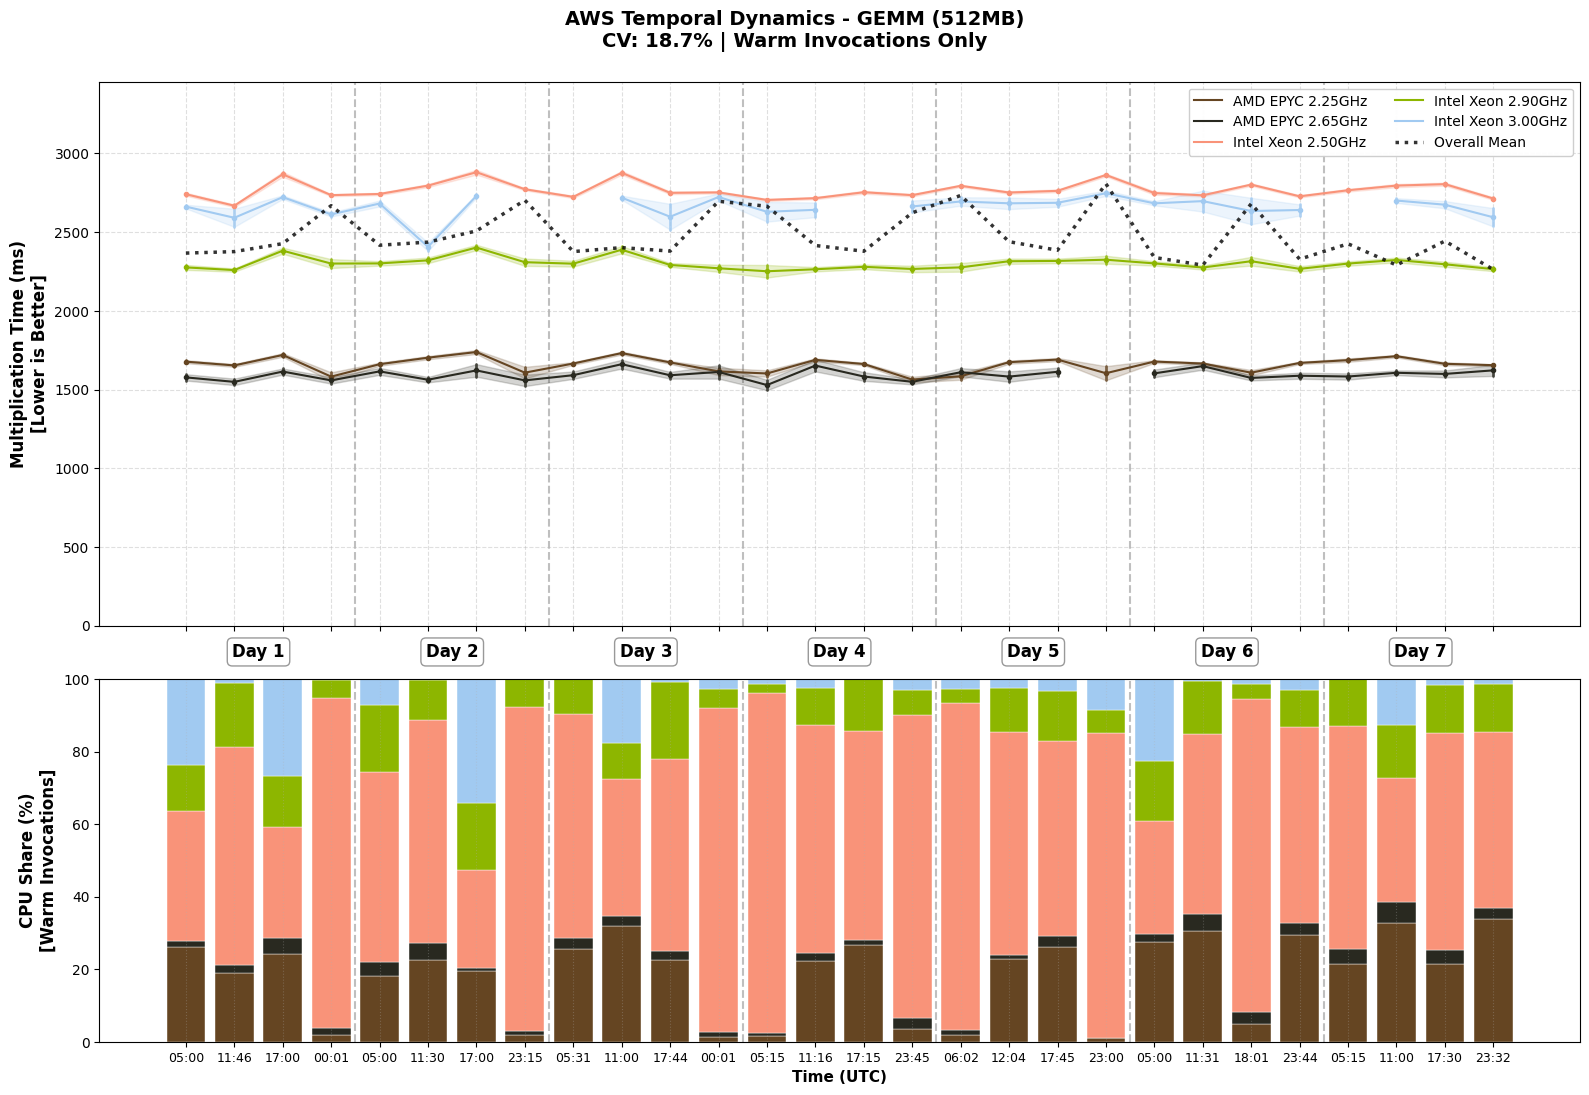


📊 CPU Distribution:
  Intel Xeon 2.50GHz: 24,618 (69.8%)
  AMD EPYC 2.25GHz: 4,320 (12.3%)
  Intel Xeon 2.90GHz: 4,041 (11.5%)
  Intel Xeon 3.00GHz: 1,392 (3.9%)
  AMD EPYC 2.65GHz: 891 (2.5%)

💾 Saved to: ../holy/graphs/StageC/aws/trends/trend_sha256_aws_512mb.pdf


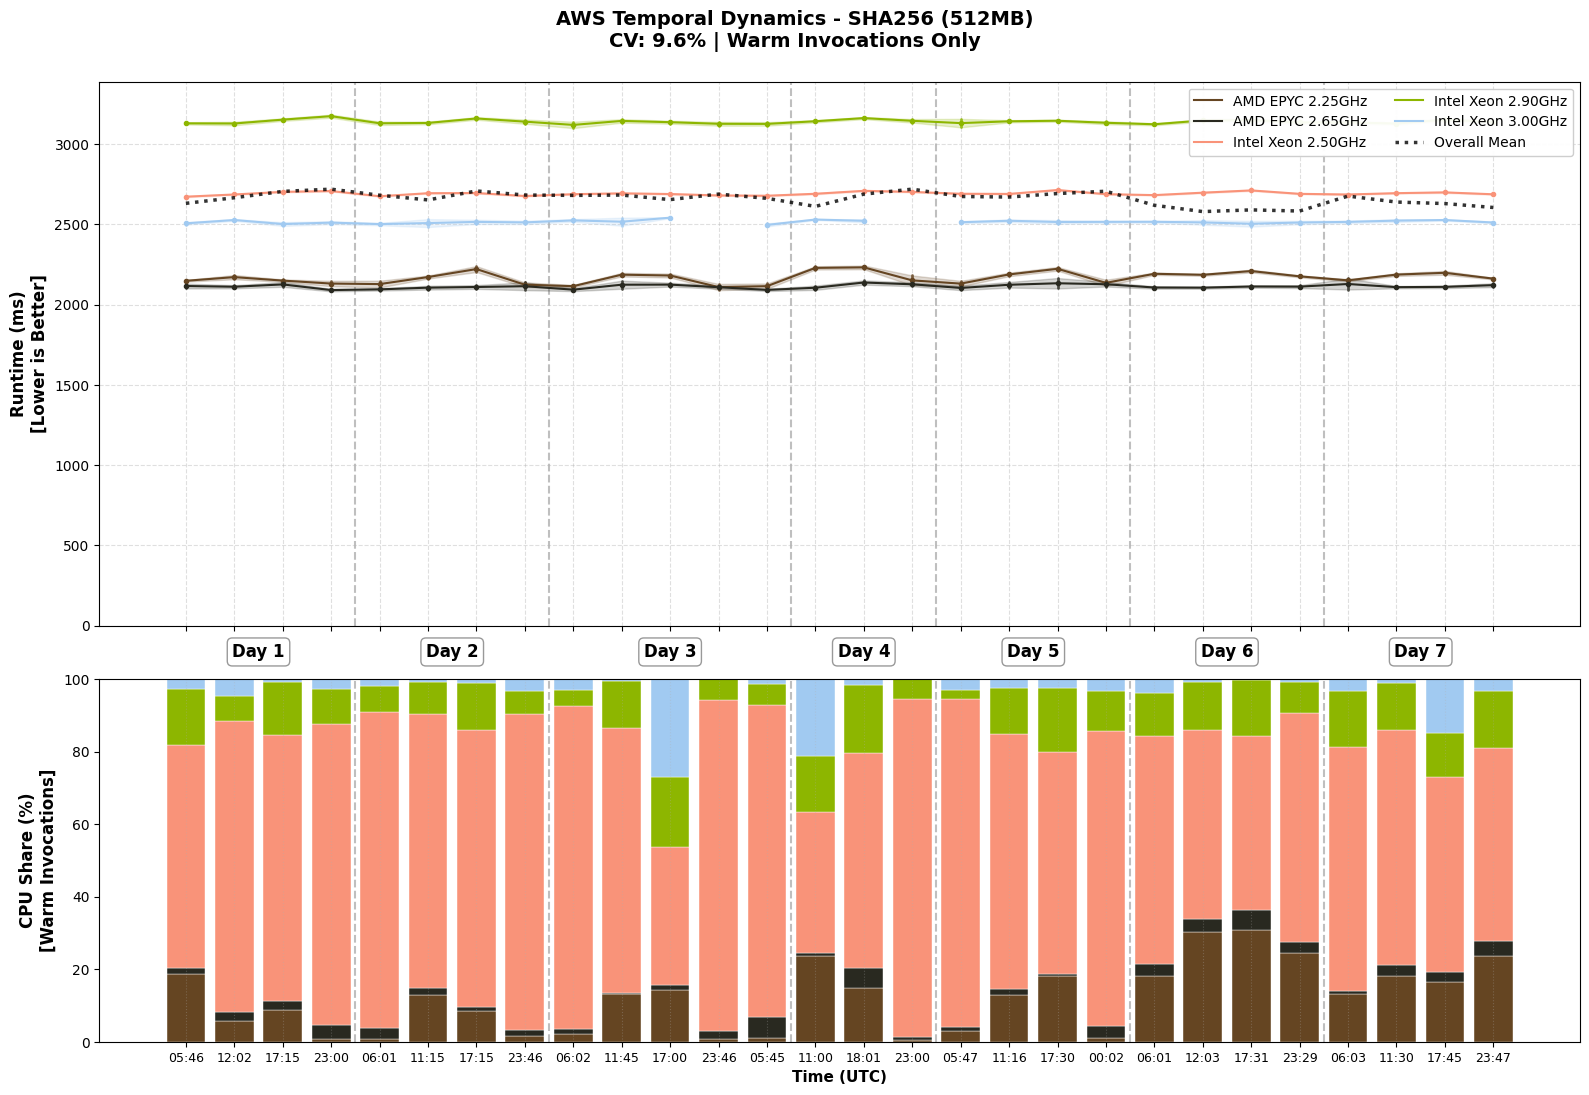


📊 CPU Distribution:
  Intel Xeon 2.50GHz: 26,892 (79.4%)
  Intel Xeon 2.90GHz: 2,922 (8.6%)
  AMD EPYC 2.25GHz: 1,965 (5.8%)
  Intel Xeon 3.00GHz: 1,572 (4.6%)
  AMD EPYC 2.65GHz: 534 (1.6%)

💾 Saved to: ../holy/graphs/StageC/aws/trends/trend_gzip_aws_512mb.pdf


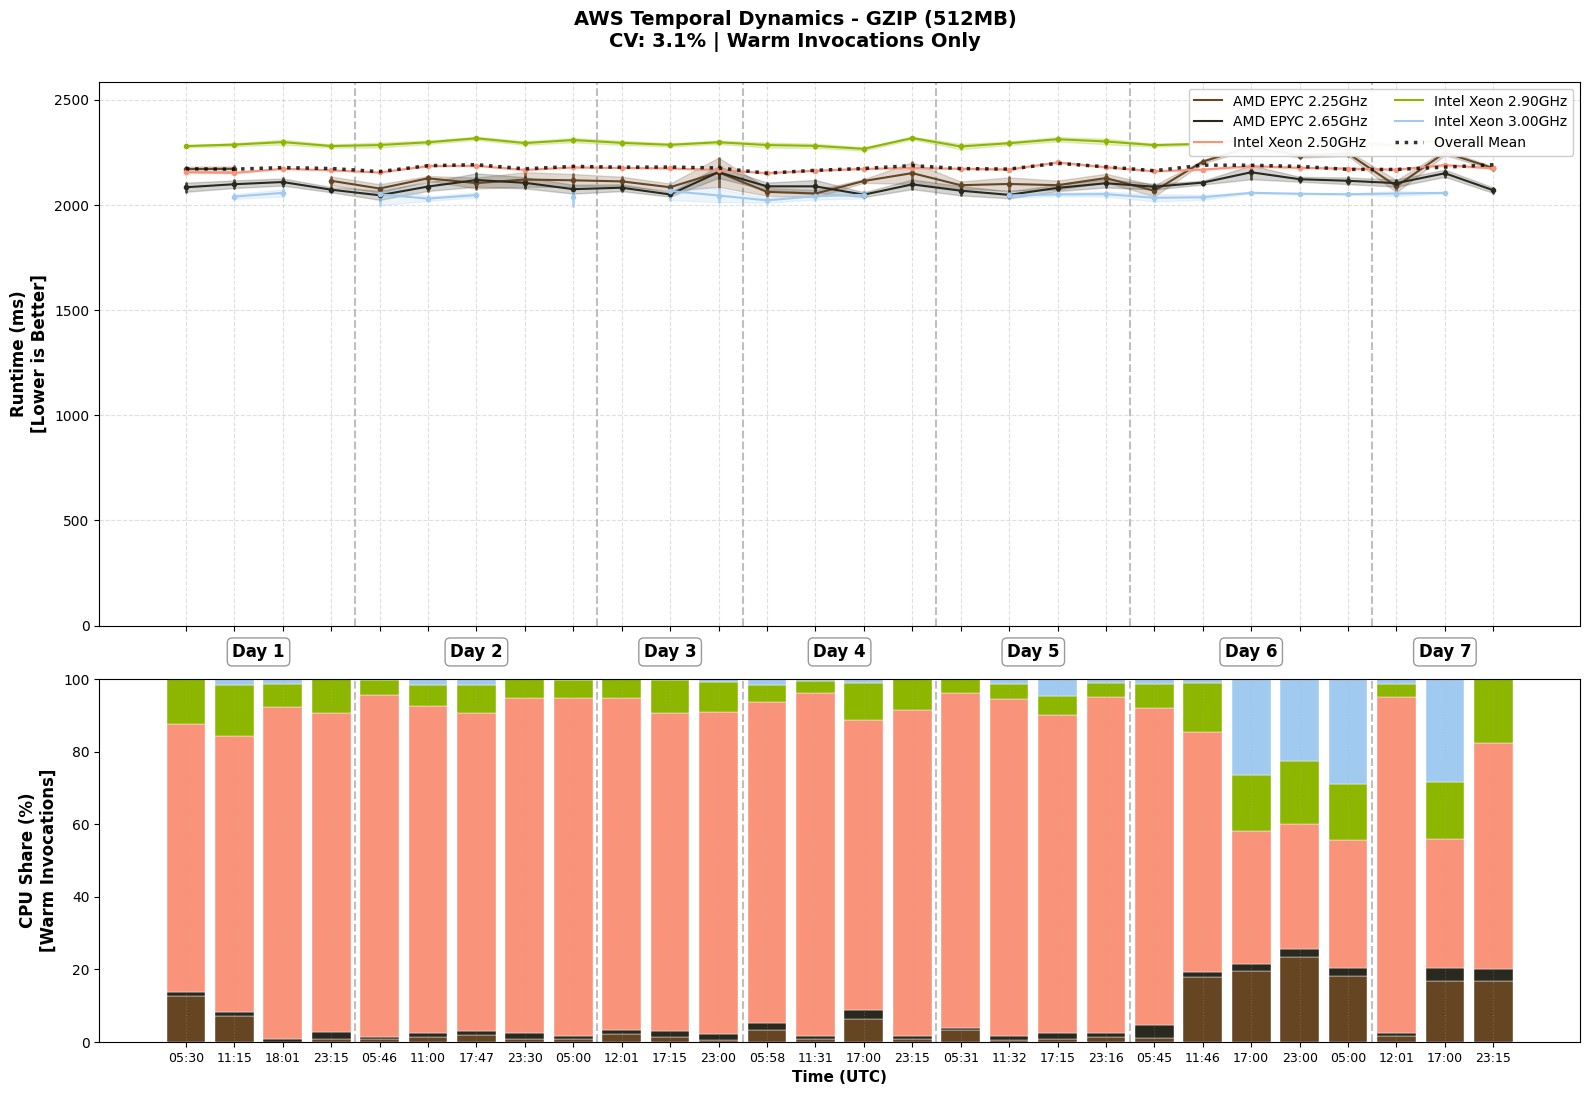


📊 CPU Distribution:
  Intel Xeon 2.50GHz: 28,836 (82.2%)
  Intel Xeon 2.90GHz: 2,706 (7.7%)
  AMD EPYC 2.25GHz: 2,277 (6.5%)
  AMD EPYC 2.65GHz: 924 (2.6%)
  Intel Xeon 3.00GHz: 321 (0.9%)

💾 Saved to: ../holy/graphs/StageC/aws/trends/trend_aesCtr_aws_512mb.pdf


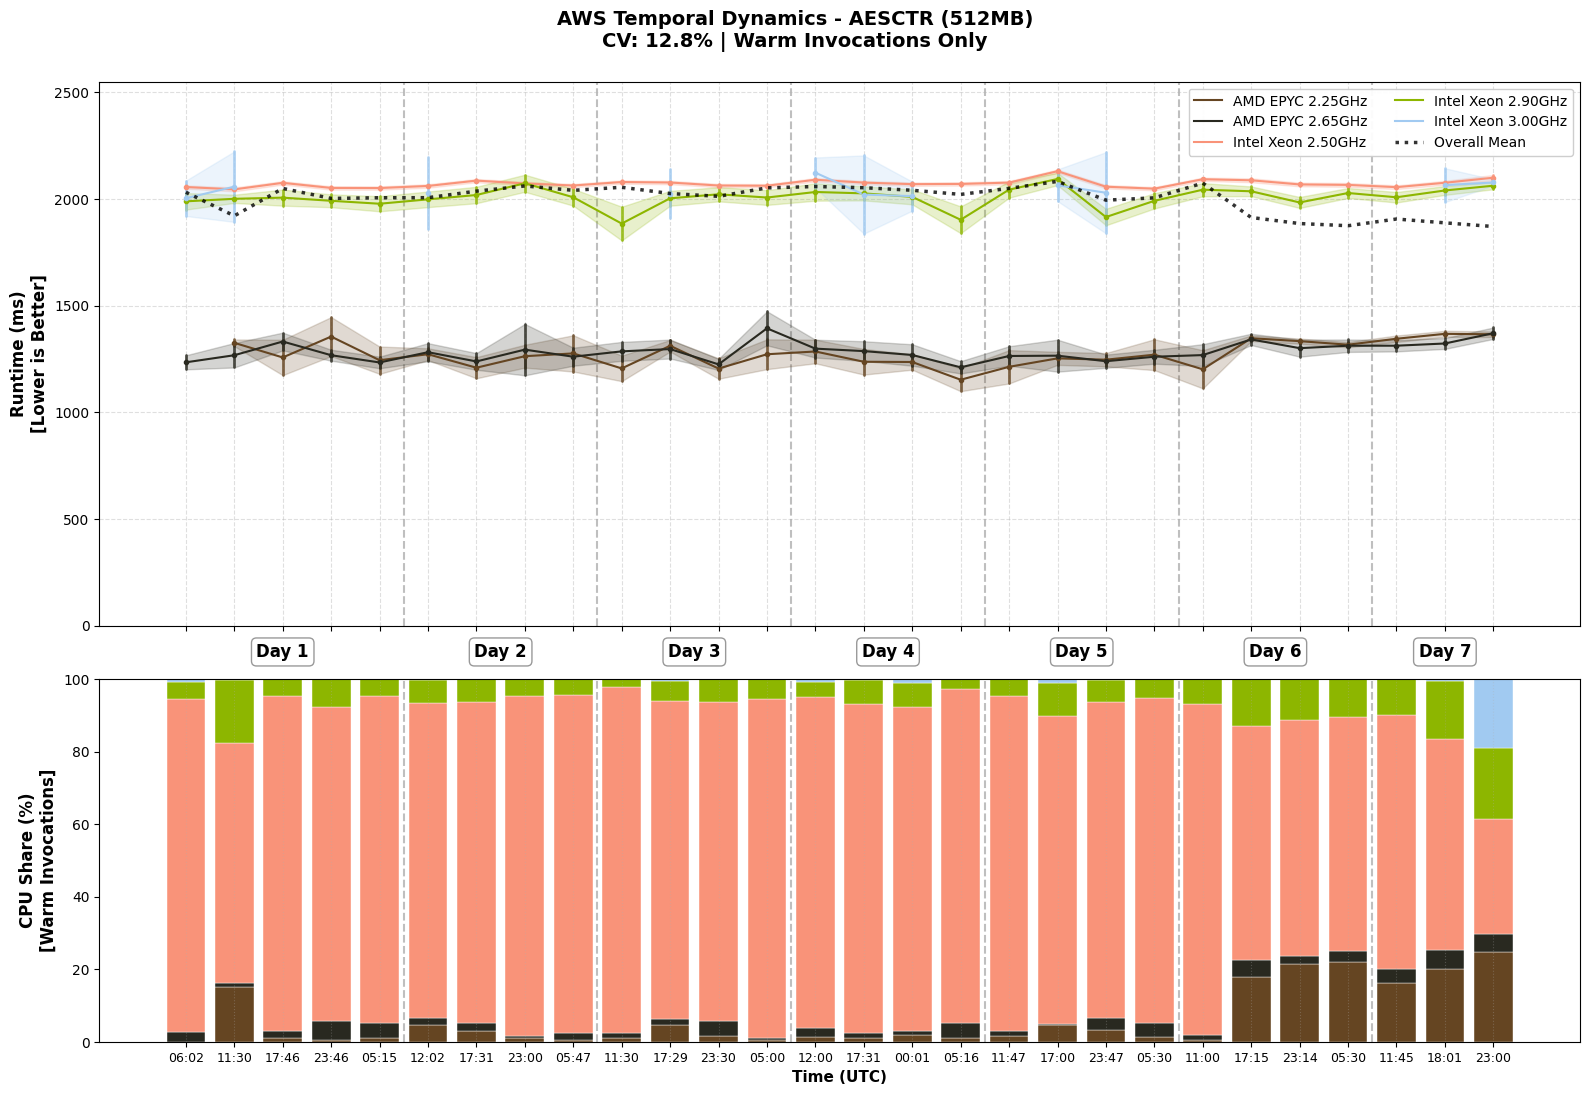


📊 CPU Distribution:
  Intel Xeon 2.50GHz: 25,386 (74.7%)
  Intel Xeon 2.90GHz: 3,390 (10.0%)
  AMD EPYC 2.25GHz: 3,216 (9.5%)
  Intel Xeon 3.00GHz: 1,401 (4.1%)
  AMD EPYC 2.65GHz: 585 (1.7%)

💾 Saved to: ../holy/graphs/StageC/aws/trends/trend_json_aws_512mb.pdf


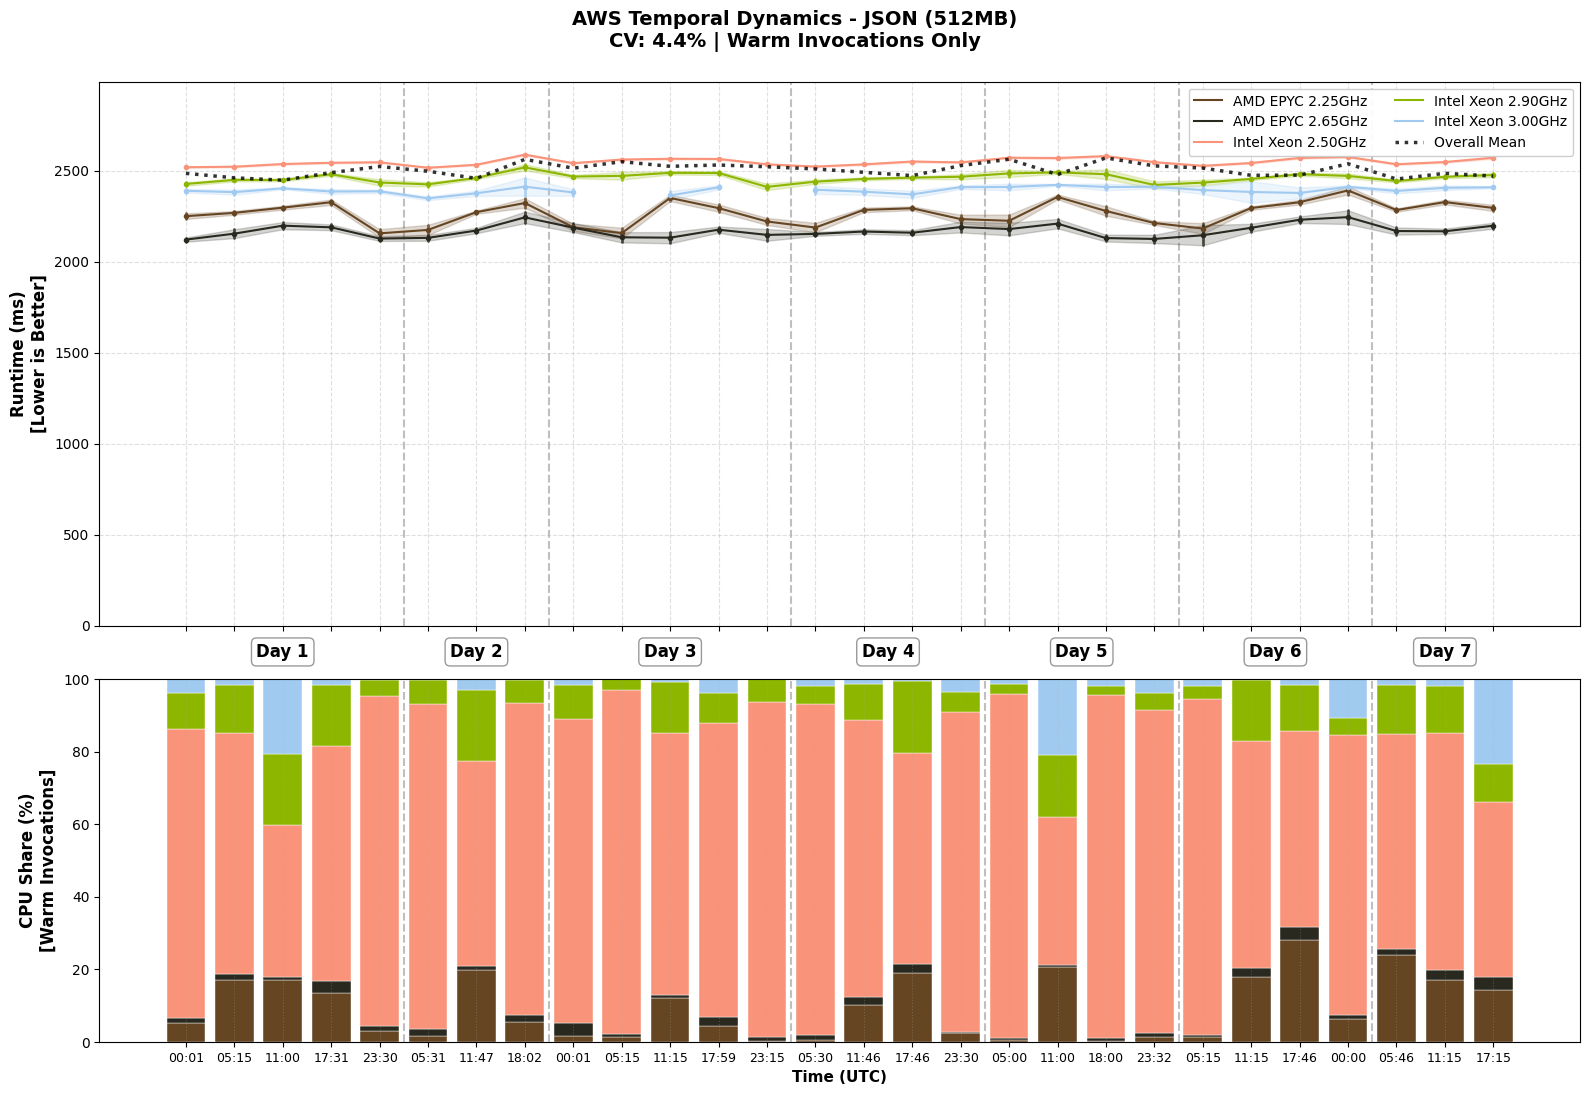

In [5]:
# aws: Second week only (Nov 10-17)
# plot_experiment_trend_robust(df, "azure", memory_size=512, benchmark="gemm",  save_dir="../holy/graphs/StageC")

# # AWS: First week (Nov 3-10)
# plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="gemm", save_dir="../holy/graphs/StageC")
# # alibaba: First week 
# plot_experiment_trend_robust(df, "alibaba", memory_size=512, benchmark="gemm", 
#                              save_dir="../holy/graphs/StageC")

# Alibaba: Specific time range
plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="gemm", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="sha256", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="gzip", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="aesCtr", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="json", 
                             save_dir="../holy/graphs/StageC")